# Transaction Data Analysis

This notebook analyzes transaction patterns and creates a graph structure for money laundering detection.

In [ ]:
!pip install polars
!pip install networkx
!pip install matplotlib

## Setup

Install required library.

In [ ]:
import polars as pl
import networkx as nx
import matplotlib.pyplot as plt

# df = pl.read_csv('data/HI-Small_Trans.csv')
# Try lazy frame
df = pl.read_csv('data/HI-Small_Trans.csv')

# Sample only 10% of full data for memory management, commented out if want full data
df = df.sample(fraction=0.10, with_replacement=False, seed=42).lazy()

G = nx.DiGraph()
SG = nx.DiGraph()

## Load Data

Read transaction data from CSV file.

In [3]:
df.collect()

Timestamp,From Bank,Account,To Bank,Account_duplicated_0,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
str,i64,str,i64,str,f64,str,f64,str,str,i64
"""2022/09/01 14:51""",122332,"""808376670""",220504,"""808763050""",165.58,"""UK Pound""",165.58,"""UK Pound""","""Cash""",0
"""2022/09/02 12:05""",70,"""100428660""",2843,"""800C08F10""",1000.0,"""US Dollar""",1000.0,"""US Dollar""","""Cheque""",0
"""2022/09/07 22:23""",14,"""8035A5A50""",3,"""8035CB140""",4449.0,"""Yuan""",4449.0,"""Yuan""","""Credit Card""",0
"""2022/09/02 15:44""",14290,"""8028B20E0""",214100,"""80B5A8EF0""",24022.22,"""Euro""",24022.22,"""Euro""","""ACH""",0
"""2022/09/01 00:28""",12735,"""803109B90""",226951,"""80A633740""",2777.01,"""US Dollar""",2777.01,"""US Dollar""","""Cheque""",0
…,…,…,…,…,…,…,…,…,…,…
"""2022/09/06 20:48""",124,"""813B87B71""",124,"""813B87B71""",0.026602,"""Bitcoin""",0.026602,"""Bitcoin""","""Bitcoin""",0
"""2022/09/02 01:05""",70,"""1004286A8""",111141,"""8144DAE90""",1614.02,"""Euro""",1614.02,"""Euro""","""Cash""",0
"""2022/09/09 12:46""",12381,"""8085123D0""",216645,"""80F2F2D50""",320.56,"""US Dollar""",320.56,"""US Dollar""","""Credit Card""",0


In [4]:
df = df.with_columns(
    pl.col('Timestamp').str.strptime(pl.Datetime, format='%Y/%m/%d %H:%M')
)

## Data Preparation

Convert timestamp column to datetime format.

In [5]:
df.collect()

Timestamp,From Bank,Account,To Bank,Account_duplicated_0,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
datetime[μs],i64,str,i64,str,f64,str,f64,str,str,i64
2022-09-01 14:51:00,122332,"""808376670""",220504,"""808763050""",165.58,"""UK Pound""",165.58,"""UK Pound""","""Cash""",0
2022-09-02 12:05:00,70,"""100428660""",2843,"""800C08F10""",1000.0,"""US Dollar""",1000.0,"""US Dollar""","""Cheque""",0
2022-09-07 22:23:00,14,"""8035A5A50""",3,"""8035CB140""",4449.0,"""Yuan""",4449.0,"""Yuan""","""Credit Card""",0
2022-09-02 15:44:00,14290,"""8028B20E0""",214100,"""80B5A8EF0""",24022.22,"""Euro""",24022.22,"""Euro""","""ACH""",0
2022-09-01 00:28:00,12735,"""803109B90""",226951,"""80A633740""",2777.01,"""US Dollar""",2777.01,"""US Dollar""","""Cheque""",0
…,…,…,…,…,…,…,…,…,…,…
2022-09-06 20:48:00,124,"""813B87B71""",124,"""813B87B71""",0.026602,"""Bitcoin""",0.026602,"""Bitcoin""","""Bitcoin""",0
2022-09-02 01:05:00,70,"""1004286A8""",111141,"""8144DAE90""",1614.02,"""Euro""",1614.02,"""Euro""","""Cash""",0
2022-09-09 12:46:00,12381,"""8085123D0""",216645,"""80F2F2D50""",320.56,"""US Dollar""",320.56,"""US Dollar""","""Credit Card""",0


Disregard transaction with Payment Format "Reinvesment"

In [6]:
df = df.filter(pl.col("Payment Format") != "Reinvestment")

In [7]:
df.collect()

Timestamp,From Bank,Account,To Bank,Account_duplicated_0,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
datetime[μs],i64,str,i64,str,f64,str,f64,str,str,i64
2022-09-01 14:51:00,122332,"""808376670""",220504,"""808763050""",165.58,"""UK Pound""",165.58,"""UK Pound""","""Cash""",0
2022-09-02 12:05:00,70,"""100428660""",2843,"""800C08F10""",1000.0,"""US Dollar""",1000.0,"""US Dollar""","""Cheque""",0
2022-09-07 22:23:00,14,"""8035A5A50""",3,"""8035CB140""",4449.0,"""Yuan""",4449.0,"""Yuan""","""Credit Card""",0
2022-09-02 15:44:00,14290,"""8028B20E0""",214100,"""80B5A8EF0""",24022.22,"""Euro""",24022.22,"""Euro""","""ACH""",0
2022-09-01 00:28:00,12735,"""803109B90""",226951,"""80A633740""",2777.01,"""US Dollar""",2777.01,"""US Dollar""","""Cheque""",0
…,…,…,…,…,…,…,…,…,…,…
2022-09-06 20:48:00,124,"""813B87B71""",124,"""813B87B71""",0.026602,"""Bitcoin""",0.026602,"""Bitcoin""","""Bitcoin""",0
2022-09-02 01:05:00,70,"""1004286A8""",111141,"""8144DAE90""",1614.02,"""Euro""",1614.02,"""Euro""","""Cash""",0
2022-09-09 12:46:00,12381,"""8085123D0""",216645,"""80F2F2D50""",320.56,"""US Dollar""",320.56,"""US Dollar""","""Credit Card""",0


## Temporal View Graph Initialization

### Create Nodes

Build graph nodes from transactions with ID, sender, receiver, time, amount, and label.

In [8]:
nodes = df.with_row_index("node_id").select([
    pl.col("node_id"),
    pl.col("Account").alias("f_i"),                # From
    pl.col("Account_duplicated_0").alias("b_i"),   # Beneficiary
    pl.col("Timestamp").alias("t_i"),              # Time
    pl.col("Amount Received").alias("a_i"),        # Amount
    pl.col("Is Laundering")                        # Ground truth
])

In [9]:
nodes.collect().head()

node_id,f_i,b_i,t_i,a_i,Is Laundering
u32,str,str,datetime[μs],f64,i64
0,"""808376670""","""808763050""",2022-09-01 14:51:00,165.58,0
1,"""100428660""","""800C08F10""",2022-09-02 12:05:00,1000.0,0
2,"""8035A5A50""","""8035CB140""",2022-09-07 22:23:00,4449.0,0
3,"""8028B20E0""","""80B5A8EF0""",2022-09-02 15:44:00,24022.22,0
4,"""803109B90""","""80A633740""",2022-09-01 00:28:00,2777.01,0


Adding nodes df into nx graph

In [10]:
# for row in nodes.collect().to_dicts():
#     G.add_node(row["node_id"], 
#                f_i=row["f_i"], 
#                b_i=row["b_i"], 
#                t_i=row["t_i"], 
#                a_i=row["a_i"], 
#                is_laundering=row["Is Laundering"])

In [11]:
# Sample some nodes to inspect
# sample_nodes = list(G.nodes)[:5]
# for node in sample_nodes:
#     print(f"Node {node}: {G.nodes[node]}")

### Create Edges

Connect transactions where one receiver becomes the sender in another transaction.

In [12]:
edges = nodes.join(
    nodes,
    left_on="b_i", 
    right_on="f_i",
    suffix="_d",
    how="inner"
).rename({"node_id": "v_s", "node_id_d": "v_d"})

In [13]:
edges.collect()

v_s,f_i,b_i,t_i,a_i,Is Laundering,v_d,b_i_d,t_i_d,a_i_d,Is Laundering_d
u32,str,str,datetime[μs],f64,i64,u32,str,datetime[μs],f64,i64
99295,"""100428810""","""808376670""",2022-09-10 12:26:00,94.14,0,0,"""808763050""",2022-09-01 14:51:00,165.58,0
225193,"""8076829F0""","""808376670""",2022-09-02 18:32:00,1537.16,0,0,"""808763050""",2022-09-01 14:51:00,165.58,0
280904,"""100428810""","""808376670""",2022-09-04 08:28:00,55.19,0,0,"""808763050""",2022-09-01 14:51:00,165.58,0
300146,"""100428810""","""808376670""",2022-09-02 01:56:00,55.19,0,0,"""808763050""",2022-09-01 14:51:00,165.58,0
13375,"""80571C290""","""100428660""",2022-09-09 06:35:00,529.2,0,1,"""800C08F10""",2022-09-02 12:05:00,1000.0,0
…,…,…,…,…,…,…,…,…,…,…
451074,"""805836AE0""","""1004286A8""",2022-09-09 16:27:00,3503.46,0,459752,"""8144DAE90""",2022-09-02 01:05:00,1614.02,0
454084,"""803BA4C60""","""1004286A8""",2022-09-02 13:23:00,1370.04,0,459752,"""8144DAE90""",2022-09-02 01:05:00,1614.02,0
69627,"""801F49CC0""","""8085123D0""",2022-09-08 00:56:00,1543.08,0,459753,"""80F2F2D50""",2022-09-09 12:46:00,320.56,0


In [14]:
timedelta = pl.duration(hours=24)

### Filter Edges

Keep only edges where the second transaction occurs within 24 hours after the first.

In [15]:
edges = edges.filter(
    (pl.col("t_i_d") > pl.col("t_i")) & 
    (pl.col("t_i_d") < pl.col("t_i") + timedelta)
)

adding edges to graph G

In [16]:
# for row in edges.select(["v_s", "v_d", "t_i", "t_i_d"]).collect().to_dicts():
#     print(row)
#     break

### Temporal View Results

Display final nodes and edges.

In [17]:
print(nodes.collect())

shape: (459_756, 6)
┌─────────┬───────────┬───────────┬─────────────────────┬──────────┬───────────────┐
│ node_id ┆ f_i       ┆ b_i       ┆ t_i                 ┆ a_i      ┆ Is Laundering │
│ ---     ┆ ---       ┆ ---       ┆ ---                 ┆ ---      ┆ ---           │
│ u32     ┆ str       ┆ str       ┆ datetime[μs]        ┆ f64      ┆ i64           │
╞═════════╪═══════════╪═══════════╪═════════════════════╪══════════╪═══════════════╡
│ 0       ┆ 808376670 ┆ 808763050 ┆ 2022-09-01 14:51:00 ┆ 165.58   ┆ 0             │
│ 1       ┆ 100428660 ┆ 800C08F10 ┆ 2022-09-02 12:05:00 ┆ 1000.0   ┆ 0             │
│ 2       ┆ 8035A5A50 ┆ 8035CB140 ┆ 2022-09-07 22:23:00 ┆ 4449.0   ┆ 0             │
│ 3       ┆ 8028B20E0 ┆ 80B5A8EF0 ┆ 2022-09-02 15:44:00 ┆ 24022.22 ┆ 0             │
│ 4       ┆ 803109B90 ┆ 80A633740 ┆ 2022-09-01 00:28:00 ┆ 2777.01  ┆ 0             │
│ …       ┆ …         ┆ …         ┆ …                   ┆ …        ┆ …             │
│ 459751  ┆ 813B87B71 ┆ 813B87B71 ┆ 2022-09-0

In [18]:
print(edges.select(["v_s", "v_d", "t_i", "t_i_d"]).collect())

shape: (350_964, 4)
┌────────┬────────┬─────────────────────┬─────────────────────┐
│ v_s    ┆ v_d    ┆ t_i                 ┆ t_i_d               │
│ ---    ┆ ---    ┆ ---                 ┆ ---                 │
│ u32    ┆ u32    ┆ datetime[μs]        ┆ datetime[μs]        │
╞════════╪════════╪═════════════════════╪═════════════════════╡
│ 15720  ┆ 1      ┆ 2022-09-02 09:51:00 ┆ 2022-09-02 12:05:00 │
│ 17905  ┆ 1      ┆ 2022-09-02 10:00:00 ┆ 2022-09-02 12:05:00 │
│ 50608  ┆ 1      ┆ 2022-09-02 07:18:00 ┆ 2022-09-02 12:05:00 │
│ 77968  ┆ 1      ┆ 2022-09-02 07:35:00 ┆ 2022-09-02 12:05:00 │
│ 78253  ┆ 1      ┆ 2022-09-02 02:02:00 ┆ 2022-09-02 12:05:00 │
│ …      ┆ …      ┆ …                   ┆ …                   │
│ 231812 ┆ 459751 ┆ 2022-09-06 02:34:00 ┆ 2022-09-06 20:48:00 │
│ 217176 ┆ 459752 ┆ 2022-09-02 00:29:00 ┆ 2022-09-02 01:05:00 │
│ 259236 ┆ 459752 ┆ 2022-09-02 00:08:00 ┆ 2022-09-02 01:05:00 │
│ 348774 ┆ 459752 ┆ 2022-09-02 00:44:00 ┆ 2022-09-02 01:05:00 │
│ 424825 ┆ 459752 ┆ 

## Second Order Graph Creation

### Edge creation

create a second order graph edges from Temporal graph's edges

In [60]:
s_edges = edges.with_columns([
    pl.concat_str([pl.col("f_i"), pl.col("b_i")], separator="->").alias("v_s"),
    pl.concat_str([pl.col("b_i"), pl.col("b_i_d")], separator="->").alias("v_d")
]).select(["v_s", "v_d"])

In [61]:
s_edges.collect().head()

v_s,v_d
str,str
"""81269FE50->100428660""","""100428660->800C08F10"""
"""8070EAE50->100428660""","""100428660->800C08F10"""
"""806018480->100428660""","""100428660->800C08F10"""
"""80D167C20->100428660""","""100428660->800C08F10"""
"""80C710A10->100428660""","""100428660->800C08F10"""


### Weight Calculation

In [62]:
# Count times where one node goes to another
s_edges_with_count = s_edges.group_by(["v_s", "v_d"]).agg([
    pl.len().alias("spec_count")
])

denom_P = s_edges.group_by("v_s").agg([
    pl.len().alias("s_to_any")
])

denom_P_prime = s_edges.group_by("v_d").agg([
    pl.len().alias("any_to_d")
])

In [63]:
print(s_edges_with_count.collect().head())

shape: (5, 3)
┌──────────────────────┬──────────────────────┬────────────┐
│ v_s                  ┆ v_d                  ┆ spec_count │
│ ---                  ┆ ---                  ┆ ---        │
│ str                  ┆ str                  ┆ u32        │
╞══════════════════════╪══════════════════════╪════════════╡
│ 8066E4480->809FA9A70 ┆ 809FA9A70->812D96AA0 ┆ 1          │
│ 8000B8AB0->8000B8AB0 ┆ 8000B8AB0->800734200 ┆ 1          │
│ 80515DAC0->100428660 ┆ 100428660->811C6E210 ┆ 1          │
│ 808809A90->100428810 ┆ 100428810->8089222E0 ┆ 1          │
│ 8051B9890->100428660 ┆ 100428660->80DBA8740 ┆ 1          │
└──────────────────────┴──────────────────────┴────────────┘


In [65]:
print(denom_P.collect().head())

print(denom_P_prime.collect().head())

shape: (5, 2)
┌──────────────────────┬──────────┐
│ v_s                  ┆ s_to_any │
│ ---                  ┆ ---      │
│ str                  ┆ u32      │
╞══════════════════════╪══════════╡
│ 80012E790->80234C5B0 ┆ 4        │
│ 803FE0740->805BABAB0 ┆ 1        │
│ 8008F2A10->801365790 ┆ 1        │
│ 1004286A8->8010D6540 ┆ 1        │
│ 808518D00->809E6D430 ┆ 1        │
└──────────────────────┴──────────┘
shape: (5, 2)
┌──────────────────────┬──────────┐
│ v_d                  ┆ any_to_d │
│ ---                  ┆ ---      │
│ str                  ┆ u32      │
╞══════════════════════╪══════════╡
│ 804FBD300->805F2EE70 ┆ 1        │
│ 8047049F0->8047049F0 ┆ 1        │
│ 800888CF0->80C4C3870 ┆ 2        │
│ 800A28DE0->80C2C9640 ┆ 1        │
│ 804B28480->8056B5840 ┆ 2        │
└──────────────────────┴──────────┘


In [68]:
s_edges_with_weight = s_edges_with_count.join(
    denom_P,
    on="v_s",
    how="left"
).join(
    denom_P_prime,
    on="v_d",
    how="left"
).with_columns([
    (pl.col("spec_count") / pl.col("s_to_any")).alias("P"),
    (pl.col("spec_count") / pl.col("any_to_d")).alias("P_prime")
]).with_columns([
    (pl.max_horizontal([pl.col("P"), pl.col("P_prime")])).alias("weight")
])

In [69]:
print(s_edges_with_weight.collect().head())

shape: (5, 8)
┌───────────────┬──────────────┬────────────┬──────────┬──────────┬──────────┬──────────┬──────────┐
│ v_s           ┆ v_d          ┆ spec_count ┆ s_to_any ┆ any_to_d ┆ P        ┆ P_prime  ┆ weight   │
│ ---           ┆ ---          ┆ ---        ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
│ str           ┆ str          ┆ u32        ┆ u32      ┆ u32      ┆ f64      ┆ f64      ┆ f64      │
╞═══════════════╪══════════════╪════════════╪══════════╪══════════╪══════════╪══════════╪══════════╡
│ 80C34BF40->10 ┆ 100428660->8 ┆ 1          ┆ 1684     ┆ 43       ┆ 0.000594 ┆ 0.023256 ┆ 0.023256 │
│ 0428660       ┆ 03A90420     ┆            ┆          ┆          ┆          ┆          ┆          │
│ 805EB63F0->10 ┆ 100428660->8 ┆ 1          ┆ 1831     ┆ 24       ┆ 0.000546 ┆ 0.041667 ┆ 0.041667 │
│ 0428660       ┆ 12473F10     ┆            ┆          ┆          ┆          ┆          ┆          │
│ 801B49C60->80 ┆ 8035292D0->8 ┆ 2          ┆ 2        ┆ 2        ┆ 1.0      

### Sanity Checking Second Order Graph

In [72]:
edges.collect().shape, s_edges_with_weight.collect().shape

((350964, 11), (305613, 8))

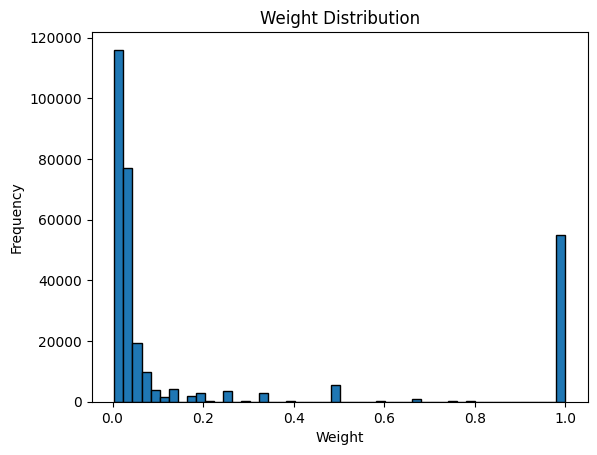

In [74]:
import matplotlib.pyplot as plt

weights = s_edges_with_weight.select("weight").collect().to_numpy().flatten()
plt.hist(weights, bins=50, edgecolor='black')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.title('Weight Distribution')
plt.show()

Text(0.5, 1.0, "P vs P' Distribution")

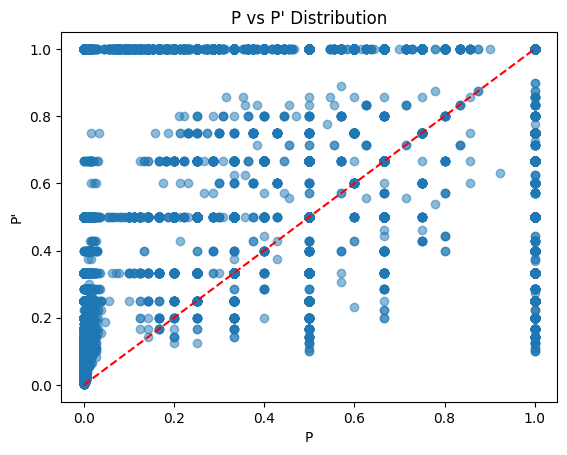

In [82]:
# P vs P_prime scatter plot (should see which dominates)
data = s_edges_with_weight.select(["P", "P_prime", "weight"]).collect()
plt.scatter(data["P"], data["P_prime"], alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')  # diagonal line
plt.xlabel('P')
plt.ylabel("P'")
plt.title("P vs P' Distribution")

In [ ]:
s_edges_with_weight.collect()

v_s,v_d,spec_count,s_to_any,any_to_d,P,P_prime,weight
str,str,u32,u32,u32,f64,f64,f64
"""813094150->100428660""","""100428660->8012DFBC0""",1,774,52,0.001292,0.019231,0.019231
"""80C522A50->1004286A8""","""1004286A8->812DB43B0""",1,1470,28,0.00068,0.035714,0.035714
"""80946A950->100428660""","""100428660->805087F50""",1,1514,83,0.000661,0.012048,0.012048
"""1004286A8->80490DC20""","""80490DC20->8093BD2F0""",1,1,1,1.0,1.0,1.0
"""8052DE170->8062663B0""","""8062663B0->806A5D4D0""",3,3,3,1.0,1.0,1.0
…,…,…,…,…,…,…,…
"""80D581FD0->80D582020""","""80D582020->80D582020""",1,1,2,1.0,0.5,1.0
"""80E5631C0->100428738""","""100428738->8039FF7D0""",1,93,3,0.010753,0.333333,0.333333
"""802DDEDC0->1004286A8""","""1004286A8->800161D40""",1,1589,30,0.000629,0.033333,0.033333


### Apply second order graph's weight to Temporal graph's edges

In [80]:
edges_with_weight = edges.with_columns([
    pl.concat_str([pl.col("f_i"), pl.col("b_i")], separator="->").alias("tx_s"),
    pl.concat_str([pl.col("b_i"), pl.col("b_i_d")], separator="->").alias("tx_d")
]).join(
    s_edges_with_weight.select([
        "v_s", "v_d", "weight"
    ]),
    left_on=["tx_s", "tx_d"],
    right_on=["v_s", "v_d"],
    how="left"
).drop([
    "tx_s", "tx_d", "v_s", "v_d"
])

In [81]:
edges_with_weight.collect()

f_i,b_i,t_i,a_i,Is Laundering,b_i_d,t_i_d,a_i_d,Is Laundering_d,weight
str,str,datetime[μs],f64,i64,str,datetime[μs],f64,i64,f64
"""81269FE50""","""100428660""",2022-09-02 09:51:00,363.25,0,"""800C08F10""",2022-09-02 12:05:00,1000.0,0,0.041667
"""8070EAE50""","""100428660""",2022-09-02 10:00:00,119.65,0,"""800C08F10""",2022-09-02 12:05:00,1000.0,0,0.041667
"""806018480""","""100428660""",2022-09-02 07:18:00,214.0,0,"""800C08F10""",2022-09-02 12:05:00,1000.0,0,0.041667
"""80D167C20""","""100428660""",2022-09-02 07:35:00,1394.66,0,"""800C08F10""",2022-09-02 12:05:00,1000.0,0,0.041667
"""80C710A10""","""100428660""",2022-09-02 02:02:00,453.76,0,"""800C08F10""",2022-09-02 12:05:00,1000.0,0,0.041667
…,…,…,…,…,…,…,…,…,…
"""8137529A1""","""813B87B71""",2022-09-06 02:34:00,0.952445,0,"""813B87B71""",2022-09-06 20:48:00,0.026602,0,1.0
"""8093BB640""","""1004286A8""",2022-09-02 00:29:00,871.28,0,"""8144DAE90""",2022-09-02 01:05:00,1614.02,0,0.25
"""80E2EFCF0""","""1004286A8""",2022-09-02 00:08:00,174.56,0,"""8144DAE90""",2022-09-02 01:05:00,1614.02,0,0.25


## Second Order Graph Creation (Incorrect)

### Node creation

create a second order node from Temporal graph's edges

In [19]:
s_nodes = edges.with_columns([
    pl.concat_str([pl.col("v_s"), pl.col("v_d")], separator="->").alias("node_id"),
    pl.col("v_s").alias("f_i"),
    pl.col("v_d").alias("b_i"),
]).select(["node_id", "f_i", "b_i"])

In [20]:
s_nodes.collect().head()

node_id,f_i,b_i
str,u32,u32
"""15720->1""",15720,1
"""17905->1""",17905,1
"""50608->1""",50608,1
"""77968->1""",77968,1
"""78253->1""",78253,1


### Edge creation

In [21]:
s_edges = s_nodes.join(
    s_nodes,
    left_on="b_i", 
    right_on="f_i",
    suffix="_d",
    how="inner"
).rename({"node_id": "v_s", "node_id_d": "v_d"})

In [22]:
s_edges.collect().head()

v_s,f_i,b_i,v_d,b_i_d
str,u32,u32,str,u32
"""81923->404989""",81923,404989,"""404989->60""",60
"""433814->404989""",433814,404989,"""404989->60""",60
"""372745->134996""",372745,134996,"""134996->62""",62
"""90193->347236""",90193,347236,"""347236->64""",64
"""417336->19969""",417336,19969,"""19969->66""",66


### Weight Calculation

In [39]:
# Count times where one node goes to another
s_edges_with_count = s_edges.group_by(["v_s", "v_d"]).agg([
    pl.len().alias("spec_count"),
    pl.col("f_i").first(),
    pl.col("b_i").first(),
    pl.col("b_i_d").first()
])

denom_P = s_edges.group_by("v_s").agg([
    pl.len().alias("s_to_any")
])

denom_P_prime = s_edges.group_by("v_d").agg([
    pl.len().alias("any_to_d")
])

In [40]:
print(s_edges_with_count.collect().head())

shape: (5, 6)
┌────────────────┬────────────────┬────────────┬────────┬────────┬────────┐
│ v_s            ┆ v_d            ┆ spec_count ┆ f_i    ┆ b_i    ┆ b_i_d  │
│ ---            ┆ ---            ┆ ---        ┆ ---    ┆ ---    ┆ ---    │
│ str            ┆ str            ┆ u32        ┆ u32    ┆ u32    ┆ u32    │
╞════════════════╪════════════════╪════════════╪════════╪════════╪════════╡
│ 358739->165769 ┆ 165769->287998 ┆ 1          ┆ 358739 ┆ 165769 ┆ 287998 │
│ 273792->284679 ┆ 284679->450261 ┆ 1          ┆ 273792 ┆ 284679 ┆ 450261 │
│ 230114->241882 ┆ 241882->264112 ┆ 1          ┆ 230114 ┆ 241882 ┆ 264112 │
│ 323753->206126 ┆ 206126->147433 ┆ 1          ┆ 323753 ┆ 206126 ┆ 147433 │
│ 451074->67350  ┆ 67350->155525  ┆ 1          ┆ 451074 ┆ 67350  ┆ 155525 │
└────────────────┴────────────────┴────────────┴────────┴────────┴────────┘


In [41]:
print(denom_P.collect().head())

print(denom_P_prime.collect().head())

shape: (5, 2)
┌────────────────┬──────────┐
│ v_s            ┆ s_to_any │
│ ---            ┆ ---      │
│ str            ┆ u32      │
╞════════════════╪══════════╡
│ 372412->37423  ┆ 1        │
│ 127780->332423 ┆ 2        │
│ 122044->377464 ┆ 1        │
│ 193253->209210 ┆ 1        │
│ 101045->331989 ┆ 2        │
└────────────────┴──────────┘
shape: (5, 2)
┌────────────────┬──────────┐
│ v_d            ┆ any_to_d │
│ ---            ┆ ---      │
│ str            ┆ u32      │
╞════════════════╪══════════╡
│ 84083->59771   ┆ 1        │
│ 403849->319233 ┆ 1        │
│ 405261->125954 ┆ 3        │
│ 213058->213532 ┆ 1        │
│ 131616->383677 ┆ 1        │
└────────────────┴──────────┘


In [45]:
s_edges_with_weight = s_edges_with_count.join(
    denom_P,
    on="v_s",
    how="left"
).join(
    denom_P_prime,
    on="v_d",
    how="left"
).with_columns([
    (pl.col("spec_count") / pl.col("s_to_any")).alias("P"),
    (pl.col("spec_count") / pl.col("any_to_d")).alias("P_prime")
]).with_columns([
    (pl.max_horizontal([pl.col("P"), pl.col("P_prime")])).alias("weight")
]).select([
    "v_s", "v_d", "spec_count", "s_to_any", "any_to_d", "P", "P_prime", "weight"
])

In [46]:
print(s_edges_with_weight.collect().head())

shape: (5, 8)
┌────────────────┬────────────────┬────────────┬──────────┬──────────┬──────────┬─────────┬────────┐
│ v_s            ┆ v_d            ┆ spec_count ┆ s_to_any ┆ any_to_d ┆ P        ┆ P_prime ┆ weight │
│ ---            ┆ ---            ┆ ---        ┆ ---      ┆ ---      ┆ ---      ┆ ---     ┆ ---    │
│ str            ┆ str            ┆ u32        ┆ u32      ┆ u32      ┆ f64      ┆ f64     ┆ f64    │
╞════════════════╪════════════════╪════════════╪══════════╪══════════╪══════════╪═════════╪════════╡
│ 199524->285656 ┆ 285656->171847 ┆ 1          ┆ 3        ┆ 1        ┆ 0.333333 ┆ 1.0     ┆ 1.0    │
│ 42842->348638  ┆ 348638->276249 ┆ 1          ┆ 1        ┆ 1        ┆ 1.0      ┆ 1.0     ┆ 1.0    │
│ 161645->293626 ┆ 293626->5445   ┆ 1          ┆ 2        ┆ 50       ┆ 0.5      ┆ 0.02    ┆ 0.5    │
│ 304219->384524 ┆ 384524->298753 ┆ 1          ┆ 2        ┆ 2        ┆ 0.5      ┆ 0.5     ┆ 0.5    │
│ 96223->72686   ┆ 72686->114262  ┆ 1          ┆ 2        ┆ 2        ┆ 0.5   

### Apply second order graph's weight to Temporal graph's edges

In [55]:
edges_with_weight = edges.with_columns([
    pl.concat_str([pl.col("f_i"), pl.col("b_i")], separator="->").alias("tx_s"),
    pl.concat_str([pl.col("b_i"), pl.col("b_i_d")], separator="->").alias("tx_d")
]).join(
    s_edges_with_weight.select([
        "v_s", "v_d", "weight"
    ]),
    left_on=["tx_s", "tx_d"],
    right_on=["v_s", "v_d"],
    how="left"
)

In [57]:
edges_with_weight.filter(pl.col("weight").is_null()).collect()

v_s,f_i,b_i,t_i,a_i,Is Laundering,v_d,b_i_d,t_i_d,a_i_d,Is Laundering_d,tx_s,tx_d,weight
u32,str,str,datetime[μs],f64,i64,u32,str,datetime[μs],f64,i64,str,str,f64
15720,"""81269FE50""","""100428660""",2022-09-02 09:51:00,363.25,0,1,"""800C08F10""",2022-09-02 12:05:00,1000.0,0,"""81269FE50->100428660""","""100428660->800C08F10""",null
17905,"""8070EAE50""","""100428660""",2022-09-02 10:00:00,119.65,0,1,"""800C08F10""",2022-09-02 12:05:00,1000.0,0,"""8070EAE50->100428660""","""100428660->800C08F10""",null
50608,"""806018480""","""100428660""",2022-09-02 07:18:00,214.0,0,1,"""800C08F10""",2022-09-02 12:05:00,1000.0,0,"""806018480->100428660""","""100428660->800C08F10""",null
77968,"""80D167C20""","""100428660""",2022-09-02 07:35:00,1394.66,0,1,"""800C08F10""",2022-09-02 12:05:00,1000.0,0,"""80D167C20->100428660""","""100428660->800C08F10""",null
78253,"""80C710A10""","""100428660""",2022-09-02 02:02:00,453.76,0,1,"""800C08F10""",2022-09-02 12:05:00,1000.0,0,"""80C710A10->100428660""","""100428660->800C08F10""",null
…,…,…,…,…,…,…,…,…,…,…,…,…,…
231812,"""8137529A1""","""813B87B71""",2022-09-06 02:34:00,0.952445,0,459751,"""813B87B71""",2022-09-06 20:48:00,0.026602,0,"""8137529A1->813B87B71""","""813B87B71->813B87B71""",null
217176,"""8093BB640""","""1004286A8""",2022-09-02 00:29:00,871.28,0,459752,"""8144DAE90""",2022-09-02 01:05:00,1614.02,0,"""8093BB640->1004286A8""","""1004286A8->8144DAE90""",null
259236,"""80E2EFCF0""","""1004286A8""",2022-09-02 00:08:00,174.56,0,459752,"""8144DAE90""",2022-09-02 01:05:00,1614.02,0,"""80E2EFCF0->1004286A8""","""1004286A8->8144DAE90""",null
